In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [3]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [4]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


# model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# model.summary()

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# iou
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
# dice coef 
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
# dice loss
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [10]:
""" Global Parameters """
H = 256
W = 256
IMAGE_SIZE = 256
NUM_CLASSES = 2

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*.jpg")))
    masks = sorted(glob(os.path.join(path, "masks", "*.jpg")))
    
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 5
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = "/content/gdrive/MyDrive/Kvasir-SEG"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    # train_x, train_y = shuffling(train_x, train_y)
    
    """ 
    downsampling
    """
    len_x_train = len(train_x)
    len_y_train = len(train_y)
    len_x_valid = len(valid_x)
    len_y_valid = len(valid_y)
   
    print(f"length of x train is :{len_x_train}")
    print(f"length of y train is :{len_y_train}")

    print(f"length of x valid is :{len_x_valid}")
    print(f"length of y valid is :{len_y_valid}")

    y_train = [train_y[x] for x in range(0,len_x_train)]
    x_valid = [valid_x[x] for x in range(0,len_y_valid)]

    print(f"Length after downsampling")
    print(f"Train: {len(train_x)} - {len(y_train)}")
    print(f"Valid: {len(x_valid)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")
   
    train_dataset = tf_dataset(train_x, y_train, batch_size)
    valid_dataset = tf_dataset(x_valid, valid_y, batch_size)
    
    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
  
    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    model.summary()
    #model = build_resunet((H, W, 3))
    # metrics = [Accuracy()]
    # model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=['accuracy'])

    # callbacks = [
                 
    #        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    #       ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    #       CSVLogger(csv_path),
    #       TensorBoard(),
    #       EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    #  ]
    # print("Running model fit :")
    # history = model.fit(
    #     train_dataset,
    #     epochs=num_epochs,
    #     validation_data=valid_dataset,
    #     steps_per_epoch=train_steps,
    #     validation_steps=valid_steps,
    #     callbacks=callbacks
    # )
    

length of x train is :700
length of y train is :800
length of x valid is :200
length of y valid is :100
Length after downsampling
Train: 700 - 700
Valid: 100 - 100
Test: 100 - 100
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
           

In [11]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=[iou,"accuracy"],
)
"""
metrics = [iou, Recall(), Precision()]
model.compile(loss=loss, optimizer=Adam(lr), metrics=metrics)
"""
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=2)

Epoch 1/2
175/175 [==============================] - 30s 128ms/step - loss: 0.3888 - iou: -0.8565 - accuracy: 0.8327 - val_loss: 0.3838 - val_iou: 0.3778 - val_accuracy: 0.8306
Epoch 2/2
175/175 [==============================] - 22s 126ms/step - loss: 0.3498 - iou: -0.4241 - accuracy: 0.8423 - val_loss: 0.4673 - val_iou: 0.1272 - val_accuracy: 0.8284


In [9]:
history.history

{'accuracy': [0.8337742686271667, 0.8420336842536926],
 'iou': [-0.994965136051178, -1.1918041706085205],
 'loss': [0.38981685042381287, 0.3508163094520569],
 'val_accuracy': [0.8306361436843872, 0.8306361436843872],
 'val_iou': [0.15522712469100952, 1.0454583168029785],
 'val_loss': [0.37086236476898193, 0.3788326680660248]}

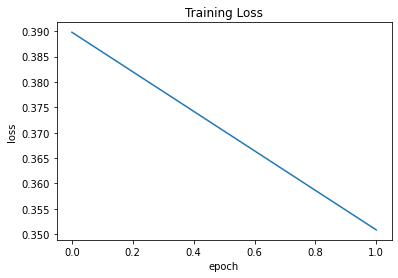

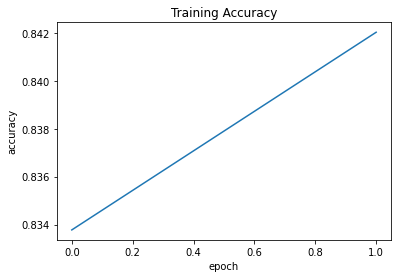

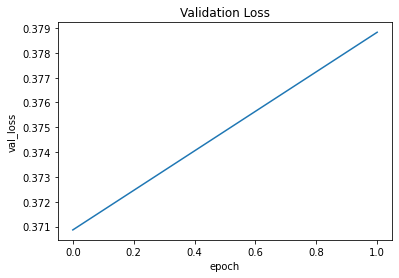

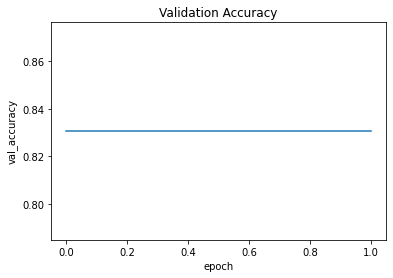

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()